<a href="https://colab.research.google.com/github/HimaniBali/Capstone/blob/master/MIMIC-iii-ml-.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking


In [2]:
# Set path (adjust if needed)
data_path = "/content/"

# Upload to Colab
from google.colab import files
uploaded = files.upload()
# Select all 4 .csv.gz files from your Downloads folder

# Load CSVs
patients = pd.read_csv(gzip.open(data_path + "PATIENTS.csv.gz"))
admissions = pd.read_csv(gzip.open(data_path + "ADMISSIONS.csv.gz"))
icustays = pd.read_csv(gzip.open(data_path + "ICUSTAYS.csv.gz"))
diagnoses = pd.read_csv(gzip.open(data_path + "DIAGNOSES_ICD.csv.gz"))


Saving PATIENTS.csv.gz to PATIENTS.csv.gz
Saving ICUSTAYS.csv.gz to ICUSTAYS.csv.gz
Saving DIAGNOSES_ICD.csv.gz to DIAGNOSES_ICD.csv.gz
Saving ADMISSIONS.csv.gz to ADMISSIONS.csv.gz


In [4]:
# Merge necessary info
df = admissions.merge(patients, on='SUBJECT_ID')
df = df.merge(icustays, on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Calculate LOS in days
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.days

# Drop rows with missing LOS
df = df.dropna(subset=['LOS'])


In [7]:
print("DOB range:", df['DOB'].min(), "to", df['DOB'].max())
print("ADMITTIME range:", df['ADMITTIME'].min(), "to", df['ADMITTIME'].max())


DOB range: 1800-07-02 00:00:00 to 2201-07-24 00:00:00
ADMITTIME range: 2100-06-07 19:59:00 to 2210-08-17 17:13:00


In [8]:
# Drop rows with missing dates
df_model = df[['GENDER', 'DOB', 'ADMITTIME', 'LOS']].copy()
df_model = df_model.dropna(subset=['DOB', 'ADMITTIME'])

# Remove impossible DOB and ADMITTIME
df_model = df_model[
    (df_model['DOB'] < df_model['ADMITTIME']) &
    (df_model['DOB'] > '1900-01-01') & (df_model['DOB'] < '2020-01-01') &
    (df_model['ADMITTIME'] > '2000-01-01') & (df_model['ADMITTIME'] < '2100-01-01')
]


In [9]:
df_model['AGE'] = (df_model['ADMITTIME'] - df_model['DOB']).dt.days // 365


In [10]:
# Try on a small sample first
sample = df_model.head(10)
sample['AGE'] = (sample['ADMITTIME'] - sample['DOB']).dt.days // 365
sample


,GENDER,DOB,ADMITTIME,LOS,AGE


In [11]:
# Drop rows with missing dates
df_model = df[['GENDER', 'DOB', 'ADMITTIME', 'LOS']].copy()
df_model = df_model.dropna(subset=['DOB', 'ADMITTIME'])

# Apply safe filters
df_model = df_model[
    (df_model['DOB'] < df_model['ADMITTIME']) &
    (df_model['DOB'] > '1900-01-01') & (df_model['DOB'] < '2020-01-01') &
    (df_model['ADMITTIME'] > '2000-01-01') & (df_model['ADMITTIME'] < '2100-01-01')
]


In [12]:
df_model['AGE'] = (df_model['ADMITTIME'] - df_model['DOB']).dt.days // 365


In [13]:
# Final dataset with cleaned values
df_model = df_model[['AGE', 'GENDER', 'LOS']].dropna()

# Encode gender: already done earlier, but just in case
df_model['GENDER'] = df_model['GENDER'].map({'M': 0, 'F': 1})

# Features (X) and Target (y)
X = df_model[['AGE', 'GENDER']]
y = df_model['LOS']


In [16]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First few rows:\n", X.head())



X shape: (0, 2)
y shape: (0,)
First few rows:
 Empty DataFrame
Columns: [AGE, GENDER]
Index: []


In [17]:
##Main

# Recreate df_model from full df
df_model = df[['GENDER', 'DOB', 'ADMITTIME', 'LOS']].copy()

# Remove nulls in critical columns
df_model = df_model.dropna(subset=['DOB', 'ADMITTIME', 'LOS', 'GENDER'])

# Filter out invalid or extreme DOB and ADMITTIME ranges
df_model = df_model[
    (df_model['DOB'] < df_model['ADMITTIME']) &
    (df_model['DOB'] > '1900-01-01') & (df_model['DOB'] < '2020-01-01') &
    (df_model['ADMITTIME'] > '2000-01-01') & (df_model['ADMITTIME'] < '2100-01-01')
]

# Calculate age
df_model['AGE'] = (df_model['ADMITTIME'] - df_model['DOB']).dt.days // 365

# Filter out negatives or unreasonable values (optional safety)
df_model = df_model[(df_model['AGE'] > 0) & (df_model['AGE'] < 120) & (df_model['LOS'] > 0)]

# Encode gender
df_model['GENDER'] = df_model['GENDER'].map({'M': 0, 'F': 1})

# Drop any rows with remaining NaNs
df_model = df_model.dropna()

# Final check
print("Cleaned df_model shape:", df_model.shape)


Cleaned df_model shape: (0, 5)


In [18]:
df_model = df[['GENDER', 'DOB', 'ADMITTIME', 'LOS']].copy()
print("Initial:", df_model.shape)


Initial: (62722, 4)


In [19]:
df_model = df_model.dropna(subset=['DOB', 'ADMITTIME', 'LOS', 'GENDER'])
print("After dropna:", df_model.shape)


After dropna: (62722, 4)


In [20]:
df_model = df_model[
    (df_model['DOB'] < df_model['ADMITTIME']) &
    (df_model['DOB'] > '1900-01-01') & (df_model['DOB'] < '2020-01-01') &
    (df_model['ADMITTIME'] > '2000-01-01') & (df_model['ADMITTIME'] < '2100-01-01')
]
print("After date filter:", df_model.shape)


After date filter: (0, 4)


In [21]:
df_model['AGE'] = (df_model['ADMITTIME'] - df_model['DOB']).dt.days // 365
print("After AGE calc:", df_model.shape)


After AGE calc: (0, 5)


In [22]:
df_model = df_model[(df_model['AGE'] > 0) & (df_model['AGE'] < 120) & (df_model['LOS'] > 0)]
print("After AGE & LOS filter:", df_model.shape)


After AGE & LOS filter: (0, 5)


In [23]:
df_model = df_model[
    (df_model['DOB'] < df_model['ADMITTIME']) &
    (df_model['DOB'] > '1900-01-01') & (df_model['DOB'] < '2025-01-01') &  # loosened upper DOB bound
    (df_model['ADMITTIME'] > '2000-01-01') & (df_model['ADMITTIME'] < '2220-01-01')  # raised upper bound
]
print("After adjusted date filter:", df_model.shape)


After adjusted date filter: (0, 5)


In [24]:
print("DOB min:", df_model['DOB'].min())
print("DOB max:", df_model['DOB'].max())
print("ADMITTIME min:", df_model['ADMITTIME'].min())
print("ADMITTIME max:", df_model['ADMITTIME'].max())


DOB min: NaT
DOB max: NaT
ADMITTIME min: NaT
ADMITTIME max: NaT


In [25]:
print(df_model[['DOB', 'ADMITTIME']].sample(5))  # sanity-check sample values


ValueError: a must be greater than 0 unless no samples are taken

In [26]:
print("DOB dtype:", df_model['DOB'].dtype)
print("ADMITTIME dtype:", df_model['ADMITTIME'].dtype)


DOB dtype: datetime64[ns]
ADMITTIME dtype: datetime64[ns]


In [27]:
df_model = df_model[
    (df_model['DOB'] < df_model['ADMITTIME']) &
    (df_model['DOB'] > '1800-01-01') &
    (df_model['ADMITTIME'] < '2300-01-01')
]
print("After relaxed filter:", df_model.shape)


After relaxed filter: (0, 5)


In [28]:
# Look for rows where DOB > ADMITTIME (which shouldn't be the case)
invalid_rows = df_model[df_model['DOB'] > df_model['ADMITTIME']]
print("DOB > ADMITTIME rows:", len(invalid_rows))

# Print some samples
print(invalid_rows[['DOB', 'ADMITTIME']].head())


DOB > ADMITTIME rows: 0
Empty DataFrame
Columns: [DOB, ADMITTIME]
Index: []


In [29]:
# Start from original full DataFrame
df_model = df[['GENDER', 'DOB', 'ADMITTIME', 'LOS']].copy()

# Explicitly convert DOB and ADMITTIME again
df_model['DOB'] = pd.to_datetime(df_model['DOB'], errors='coerce')
df_model['ADMITTIME'] = pd.to_datetime(df_model['ADMITTIME'], errors='coerce')

# Now drop rows with any missing values
df_model = df_model.dropna(subset=['DOB', 'ADMITTIME', 'LOS', 'GENDER'])

# Check again
print("After fresh datetime conversion and dropna:", df_model.shape)
print(df_model[['DOB', 'ADMITTIME']].head())


After fresh datetime conversion and dropna: (62722, 4)
         DOB           ADMITTIME
0 2131-05-07 2196-04-09 12:26:00
1 2082-07-17 2153-09-03 07:15:00
2 2082-07-17 2157-10-18 19:34:00
3 2100-05-31 2139-06-06 16:14:00
4 2101-11-21 2160-11-02 02:06:00


In [30]:
df_model = df_model[
    (df_model['DOB'] < df_model['ADMITTIME']) &
    (df_model['DOB'] > '1800-01-01') &
    (df_model['ADMITTIME'] < '2300-01-01')
]


In [32]:
# Use year difference instead of full timedelta to avoid overflow
df_model['AGE'] = df_model['ADMITTIME'].dt.year - df_model['DOB'].dt.year

# Drop impossible ages
df_model = df_model[(df_model['AGE'] > 0) & (df_model['AGE'] < 120)]

# Final check
print("Shape after computing AGE safely:", df_model.shape)
print(df_model[['AGE']].describe())


Shape after computing AGE safely: (51769, 5)
                AGE
count  51769.000000
mean      62.547741
std       16.554670
min        1.000000
25%       52.000000
50%       64.000000
75%       76.000000
max       89.000000


In [42]:
X = df_model[['AGE', 'GENDER']]
y = df_model['LOS']


In [44]:
# Convert to string first, then uppercase
df_model['GENDER'] = df_model['GENDER'].astype(str).str.upper()

# Keep only M and F
df_model = df_model[df_model['GENDER'].isin(['M', 'F'])]

# Map gender to numeric
df_model['GENDER'] = df_model['GENDER'].map({'M': 0, 'F': 1})

# Final check
print("Unique values in GENDER:", df_model['GENDER'].unique())


Unique values in GENDER: []


In [45]:
X = df_model[['AGE', 'GENDER']]
y = df_model['LOS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 41415 Test size: 10354


In [35]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)


ValueError: could not convert string to float: 'M'

In [46]:
print("Unique raw GENDER values (before filtering):")
print(df['GENDER'].value_counts(dropna=False))


Unique raw GENDER values (before filtering):
GENDER
M    35121
F    27601
Name: count, dtype: int64


In [47]:
# Convert gender to uppercase (not really needed here but safe)
df_model['GENDER'] = df_model['GENDER'].astype(str).str.upper()

# Keep only valid gender values
df_model = df_model[df_model['GENDER'].isin(['M', 'F'])]

# Map to numeric
df_model['GENDER'] = df_model['GENDER'].map({'M': 0, 'F': 1})

# Now define X and y AFTER the cleanup
X = df_model[['AGE', 'GENDER']]
y = df_model['LOS']

print("Final X shape:", X.shape)
print("Unique values in cleaned GENDER:", df_model['GENDER'].unique())


Final X shape: (0, 2)
Unique values in cleaned GENDER: []


In [48]:
# Start from full dataset that has AGE and LOS
df_model = df[['GENDER', 'DOB', 'ADMITTIME', 'DISCHTIME']].copy()

# Convert date columns again
df_model['DOB'] = pd.to_datetime(df_model['DOB'], errors='coerce')
df_model['ADMITTIME'] = pd.to_datetime(df_model['ADMITTIME'], errors='coerce')
df_model['DISCHTIME'] = pd.to_datetime(df_model['DISCHTIME'], errors='coerce')

# Drop missing
df_model = df_model.dropna(subset=['DOB', 'ADMITTIME', 'DISCHTIME', 'GENDER'])

# Compute LOS and AGE
df_model['LOS'] = (df_model['DISCHTIME'] - df_model['ADMITTIME']).dt.days
df_model['AGE'] = df_model['ADMITTIME'].dt.year - df_model['DOB'].dt.year

# Filter based on valid ages and LOS
df_model = df_model[(df_model['AGE'] > 0) & (df_model['AGE'] < 120)]
df_model = df_model[df_model['LOS'] > 0]

# Fix gender safely
df_model['GENDER'] = df_model['GENDER'].astype(str).str.upper()
df_model = df_model[df_model['GENDER'].isin(['M', 'F'])]
df_model['GENDER'] = df_model['GENDER'].map({'M': 0, 'F': 1})

# Final dataset
df_model = df_model[['AGE', 'GENDER', 'LOS']].dropna()
print("Final cleaned shape:", df_model.shape)


Final cleaned shape: (49872, 3)


In [49]:
X = df_model[['AGE', 'GENDER']]
y = df_model['LOS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ MAE: {mae:.2f} days")
print(f"✅ RMSE: {rmse:.2f} days")


✅ MAE: 8.24 days
✅ RMSE: 13.91 days


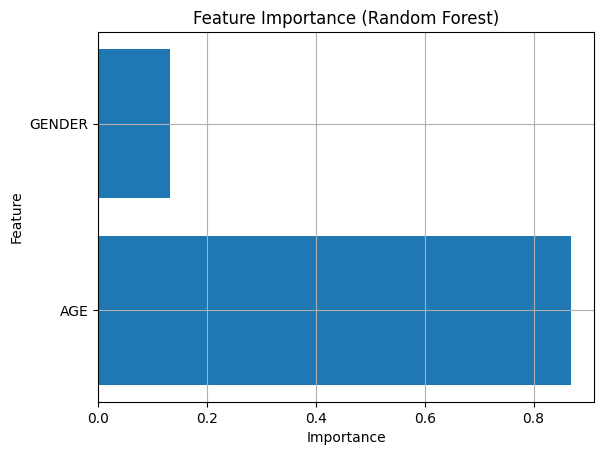

In [50]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


In [52]:
# Create ICU label: 1 if subject was ever in ICU
icu_subjects = icustays['SUBJECT_ID'].unique()
df['ICU_YES'] = df['SUBJECT_ID'].isin(icu_subjects).astype(int)

# Recompute AGE (from earlier logic)
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], errors='coerce')
df['AGE'] = df['ADMITTIME'].dt.year - df['DOB'].dt.year

# Keep only valid rows
df_model2 = df[['AGE', 'GENDER', 'ICU_YES']].dropna()
df_model2 = df_model2[(df_model2['AGE'] > 0) & (df_model2['AGE'] < 120)]
df_model2 = df_model2[df_model2['GENDER'].isin(['M', 'F'])]

# Encode gender
df_model2['GENDER'] = df_model2['GENDER'].map({'M': 0, 'F': 1})


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X2 = df_model2[['AGE', 'GENDER']]
y2 = df_model2['ICU_YES']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X2_train, y2_train)

y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       1.00      1.00      1.00     10348

    accuracy                           1.00     10354
   macro avg       0.50      0.50      0.50     10354
weighted avg       1.00      1.00      1.00     10354



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
# Separate classes
df_pos = df_model2[df_model2['ICU_YES'] == 1]
df_neg = df_model2[df_model2['ICU_YES'] == 0]

# Downsample positive class to match the size of negative class (or vice versa if needed)
sample_size = min(len(df_pos), len(df_neg))
df_balanced = pd.concat([
    df_pos.sample(sample_size, random_state=42),
    df_neg.sample(sample_size, random_state=42)
])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42)


In [55]:
Xb = df_balanced[['AGE', 'GENDER']]
yb = df_balanced['ICU_YES']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42)

clf_bal = LogisticRegression()
clf_bal.fit(Xb_train, yb_train)

yb_pred = clf_bal.predict(Xb_test)
print(classification_report(yb_test, yb_pred))


              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.36      0.57      0.44         7

    accuracy                           0.38        16
   macro avg       0.38      0.40      0.37        16
weighted avg       0.38      0.38      0.36        16

